i: 0 j: 0 nb: 392 cost: 1.9271174669265747 error rate: 0.778
i: 0 j: 20 nb: 392 cost: 1.9260836839675903 error rate: 0.774
i: 0 j: 40 nb: 392 cost: 1.9548965692520142 error rate: 0.857
i: 0 j: 60 nb: 392 cost: 1.9224631786346436 error rate: 0.791
i: 0 j: 80 nb: 392 cost: 1.9157078266143799 error rate: 0.809
i: 0 j: 100 nb: 392 cost: 1.9007320404052734 error rate: 0.799
i: 0 j: 120 nb: 392 cost: 1.8933511972427368 error rate: 0.765
i: 0 j: 140 nb: 392 cost: 1.8289865255355835 error rate: 0.721
i: 0 j: 160 nb: 392 cost: 1.8324651718139648 error rate: 0.695
i: 0 j: 180 nb: 392 cost: 1.8497551679611206 error rate: 0.775
i: 0 j: 200 nb: 392 cost: 1.8495993614196777 error rate: 0.712
i: 0 j: 220 nb: 392 cost: 1.833014965057373 error rate: 0.734
i: 0 j: 240 nb: 392 cost: 1.8144853115081787 error rate: 0.72
i: 0 j: 260 nb: 392 cost: 1.8059289455413818 error rate: 0.7
i: 0 j: 280 nb: 392 cost: 1.8331515789031982 error rate: 0.75
i: 0 j: 300 nb: 392 cost: 1.7866369485855103 error rate: 0.708
i: 

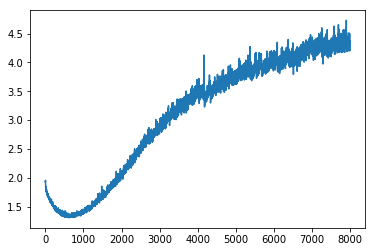

In [3]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

def error_rate(p, t):
    return np.mean(p != t)

def getData(balance_ones=True):
    # images are 48x48 = 2304 size vectors
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open('/Users/ggiorcelli/downloads/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)

    if balance_ones:
        # balance the 1 class
        X0, Y0 = X[Y!=1, :], Y[Y!=1]
        X1 = X[Y==1, :]
        X1 = np.repeat(X1, 9, axis=0)
        X = np.vstack([X0, X1])
        Y = np.concatenate((Y0, [1]*len(X1)))

    return X, Y

def getBinaryData():
    Y = []
    X = []
    first = True
    for line in open('/Users/ggiorcelli/downloads/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            y = int(row[0])
            if y == 0 or y == 1:
                Y.append(y)
                X.append([int(p) for p in row[1].split()])
    return np.array(X) / 255.0, np.array(Y)

def init_weight_and_bias(M1, M2):
    W = np.random.randn(M1, M2) / np.sqrt(M1 + M2)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)

def relu(x):
    return x * (x > 0)

def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind


class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W, b = init_weight_and_bias(M1, M2)
        self.W = theano.shared(W, 'W_%s' % self.id)
        self.b = theano.shared(b, 'b_%s' % self.id)
        self.params = [self.W, self.b]

    def forward(self, X):
        return relu(X.dot(self.W) + self.b)


class ANN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, learning_rate=10e-7, mu=0.99, decay=0.999, reg=10e-12, eps=10e-10, epochs=400, batch_sz=100, show_fig=False):
        learning_rate = np.float32(learning_rate)
        mu = np.float32(mu)
        decay = np.float32(decay)
        reg = np.float32(reg)
        eps = np.float32(eps)

        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.int32)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]

        # initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W, b = init_weight_and_bias(M1, K)
        self.W = theano.shared(W, 'W_logreg')
        self.b = theano.shared(b, 'b_logreg')

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # for momentum
        dparams = [theano.shared(np.zeros(p.get_value().shape, dtype=np.float32)) for p in self.params]

        # for rmsprop
        cache = [theano.shared(np.zeros(p.get_value().shape, dtype=np.float32)) for p in self.params]

        # set up theano functions and variables
        thX = T.fmatrix('X')
        thY = T.ivector('Y')
        pY = self.th_forward(thX)

        rcost = reg*T.sum([(p*p).sum() for p in self.params])
        cost = -T.mean(T.log(pY[T.arange(thY.shape[0]), thY])) + rcost
        prediction = self.th_predict(thX)

        # actual prediction function
        self.predict_op = theano.function(inputs=[thX], outputs=prediction)
        cost_predict_op = theano.function(inputs=[thX, thY], outputs=[cost, prediction])

        updates = [
            (c, decay*c + (np.float32(1)-decay)*T.grad(cost, p)*T.grad(cost, p)) for p, c in zip(self.params, cache)
        ] + [
            (p, p + mu*dp - learning_rate*T.grad(cost, p)/T.sqrt(c + eps)) for p, c, dp in zip(self.params, cache, dparams)
        ] + [
            (dp, mu*dp - learning_rate*T.grad(cost, p)/T.sqrt(c + eps)) for p, c, dp in zip(self.params, cache, dparams)
        ]

        # momentum only
        # updates = [
        #     (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, dparams)
        # ] + [
        #     (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, dparams)
        # ]

        train_op = theano.function(
            inputs=[thX, thY],
            updates=updates
        )

        n_batches = N // batch_sz
        costs = []
        for i in range(epochs):
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                train_op(Xbatch, Ybatch)

                if j % 20 == 0:
                    c, p = cost_predict_op(Xvalid, Yvalid)
                    costs.append(c)
                    e = error_rate(Yvalid, p)
                    print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        
        if show_fig:
            plt.plot(costs)
            plt.show()

    def th_forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return T.nnet.softmax(Z.dot(self.W) + self.b)

    def th_predict(self, X):
        pY = self.th_forward(X)
        return T.argmax(pY, axis=1)

    def predict(self, X):
        return self.predict_op(X)


def main():
    X, Y = getData()
    # X, Y = getBinaryData()
    model = ANN([2000, 1000])
    model.fit(X, Y, show_fig=True)

if __name__ == '__main__':
    main()